# XGBOOST
## Обучение дерева на синтезированных данных -> проверка на реальных 
## Это будет являться критерием, по которому можно оценить соответствие синтезированных данных реальным. 
## (Задача бинарной классификации)
###  Обучение и проверка дерева на реальных данных дает дает разделение с roc_auc = 0.64, accuracy = 0.64. Возьмем эти значения за эталон.

In [1]:
import pandas as pd
import uproot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.utils import shuffle
import matplotlib
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
import sklearn.metrics

In [2]:
data = pd.read_csv('example.csv')


data.drop(data.columns[[0]], axis  =1, inplace = True)

data = data.reset_index()
data.drop(data.columns[[0]], axis  =1, inplace = True)

In [3]:
data

,TimeAtHeightX1,TimeAtHeightX2,TimeAtHeightX3,TimeAtHeightX4,TimeAtHeightX5,TimeAtHeightX6,TimeAtHeightX7,TimeAtHeightX8,TimeAtHeightX9,TimeAtHeightX10,...,derivative40,derivative41,derivative42,derivative43,derivative44,derivative45,derivative46,derivative47,derivative48,label
0,0,0.047859,0.084551,0.119299,0.155299,0.188761,0.223149,0.255443,0.288945,0.321843,...,1.540579,1.430623,1.270883,1.167746,1.011350,0.843084,0.706976,0.570329,0.470712,1
1,0,0.066097,0.122598,0.178579,0.227855,0.260765,0.286020,0.308475,0.330446,0.353333,...,2.390753,2.195069,2.012476,1.793677,1.571206,1.298550,0.967746,0.624266,0.389749,1
2,0,0.042451,0.080758,0.109641,0.133549,0.159071,0.185241,0.207271,0.228389,0.250128,...,1.877956,1.696454,1.521908,1.332911,1.236557,1.057073,0.906059,0.655561,0.456230,1
3,0,0.050162,0.081531,0.107799,0.136899,0.165083,0.188978,0.211104,0.232359,0.250481,...,1.235579,1.150491,1.049673,1.021887,0.971848,0.864543,0.629699,0.330931,0.235175,1
4,0,0.051562,0.084981,0.113827,0.140121,0.164231,0.187563,0.209352,0.231103,0.252877,...,1.478314,1.358085,1.159338,1.038692,0.872182,0.683760,0.543124,0.450250,0.332624,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105261,0,0.035229,0.060083,0.080566,0.099828,0.118521,0.137276,0.157294,0.177510,0.197362,...,1.819971,1.651582,1.467199,1.182612,0.924744,0.820752,0.780330,0.698185,0.549837,0
105262,0,0.028220,0.044297,0.056458,0.066501,0.075623,0.084557,0.092995,0.101227,0.108975,...,0.682753,0.599837,0.575535,0.451622,0.408759,0.361819,0.399182,0.451672,0.381891,0
105263,0,0.028212,0.054477,0.076754,0.099435,0.123540,0.150332,0.179216,0.214623,0.247511,...,2.079883,2.063659,2.037960,1.720436,1.409806,1.091599,0.771979,0.480613,0.362896,0
105264,0,0.029620,0.050797,0.067901,0.082770,0.096459,0.109997,0.122814,0.135166,0.146975,...,0.784742,0.753556,0.741357,0.638862,0.621169,0.572627,0.553427,0.523062,0.399908,0


In [4]:
data.drop('TimeAtHeightX1', axis = 1, inplace = True)
data.drop('TimeAtHeightX50', axis = 1, inplace = True)


for i in range(1, 49):
    data.drop('derivative'+str(i), axis = 1, inplace = True)

In [5]:
data

,TimeAtHeightX2,TimeAtHeightX3,TimeAtHeightX4,TimeAtHeightX5,TimeAtHeightX6,TimeAtHeightX7,TimeAtHeightX8,TimeAtHeightX9,TimeAtHeightX10,TimeAtHeightX11,...,TimeAtHeightX41,TimeAtHeightX42,TimeAtHeightX43,TimeAtHeightX44,TimeAtHeightX45,TimeAtHeightX46,TimeAtHeightX47,TimeAtHeightX48,TimeAtHeightX49,label
0,0.047859,0.084551,0.119299,0.155299,0.188761,0.223149,0.255443,0.288945,0.321843,0.357933,...,0.761236,0.775216,0.790953,0.808080,0.827855,0.851578,0.879867,0.914935,0.957423,1
1,0.066097,0.122598,0.178579,0.227855,0.260765,0.286020,0.308475,0.330446,0.353333,0.377823,...,0.708679,0.717790,0.727728,0.738878,0.751607,0.767009,0.787676,0.819713,0.871028,1
2,0.042451,0.080758,0.109641,0.133549,0.159071,0.185241,0.207271,0.228389,0.250128,0.272917,...,0.673597,0.685386,0.698527,0.713532,0.729706,0.748626,0.770700,0.801208,0.845046,1
3,0.050162,0.081531,0.107799,0.136899,0.165083,0.188978,0.211104,0.232359,0.250481,0.268702,...,0.649186,0.666570,0.685623,0.705195,0.725774,0.748908,0.780669,0.841105,0.926148,1
4,0.051562,0.084981,0.113827,0.140121,0.164231,0.187563,0.209352,0.231103,0.252877,0.276163,...,0.651205,0.665931,0.683183,0.702438,0.725369,0.754619,0.791443,0.835863,0.895991,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105261,0.035229,0.060083,0.080566,0.099828,0.118521,0.137276,0.157294,0.177510,0.197362,0.217133,...,0.578607,0.590717,0.604348,0.621260,0.642887,0.667255,0.692885,0.721531,0.757906,0
105262,0.028220,0.044297,0.056458,0.066501,0.075623,0.084557,0.092995,0.101227,0.108975,0.116525,...,0.451851,0.485193,0.519943,0.564228,0.613157,0.668433,0.718536,0.762816,0.815186,0
105263,0.028212,0.054477,0.076754,0.099435,0.123540,0.150332,0.179216,0.214623,0.247511,0.274846,...,0.657559,0.667250,0.677064,0.688689,0.702875,0.721197,0.747104,0.788718,0.843830,0
105264,0.029620,0.050797,0.067901,0.082770,0.096459,0.109997,0.122814,0.135166,0.146975,0.158749,...,0.607244,0.633785,0.660762,0.692068,0.724265,0.759192,0.795330,0.833567,0.883578,0


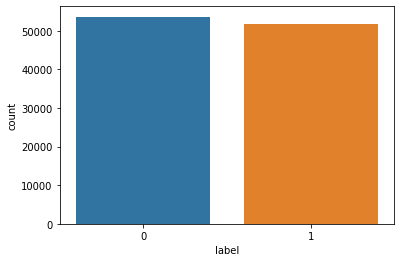

In [6]:
sns.countplot(x = 'label', data=data)

## Обучение

In [7]:
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(data.iloc[:,0:-1],data.iloc[:,-1],test_size=0.3, random_state=1)

In [8]:
train_X

,TimeAtHeightX2,TimeAtHeightX3,TimeAtHeightX4,TimeAtHeightX5,TimeAtHeightX6,TimeAtHeightX7,TimeAtHeightX8,TimeAtHeightX9,TimeAtHeightX10,TimeAtHeightX11,...,TimeAtHeightX40,TimeAtHeightX41,TimeAtHeightX42,TimeAtHeightX43,TimeAtHeightX44,TimeAtHeightX45,TimeAtHeightX46,TimeAtHeightX47,TimeAtHeightX48,TimeAtHeightX49
3698,0.041976,0.075387,0.105304,0.129513,0.149632,0.166894,0.181555,0.196115,0.210309,0.225491,...,0.517189,0.525679,0.535391,0.546208,0.558698,0.573615,0.591575,0.615405,0.648455,0.853431
59651,0.026389,0.048843,0.066737,0.082903,0.098320,0.113740,0.129811,0.146864,0.164109,0.182240,...,0.627084,0.636871,0.646639,0.656502,0.667404,0.680003,0.694070,0.710077,0.729789,0.758629
69007,0.015223,0.028627,0.039569,0.049044,0.058245,0.067920,0.077868,0.087799,0.097569,0.107517,...,0.344110,0.357862,0.373515,0.391228,0.414907,0.445156,0.478053,0.507482,0.534906,0.568602
80211,0.049738,0.078927,0.102418,0.124623,0.144437,0.163127,0.183343,0.202496,0.221438,0.238715,...,0.654190,0.662645,0.671514,0.681449,0.693562,0.709252,0.727870,0.749601,0.779859,0.940531
9896,0.032734,0.064811,0.093634,0.122424,0.150066,0.176191,0.200587,0.226782,0.254580,0.283236,...,0.713603,0.723650,0.734669,0.746443,0.759919,0.774795,0.791997,0.811777,0.835224,0.864240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50057,0.046554,0.071080,0.091060,0.107553,0.122397,0.137351,0.152285,0.167480,0.183024,0.199613,...,0.605894,0.615320,0.625580,0.636341,0.648367,0.661787,0.678013,0.698717,0.727512,0.786575
98047,0.033115,0.053655,0.068628,0.081426,0.093359,0.105318,0.117819,0.130267,0.142956,0.156501,...,0.549199,0.559357,0.569650,0.580236,0.591673,0.604954,0.619339,0.635232,0.654594,0.686228
5192,0.053502,0.078505,0.097847,0.113549,0.127102,0.139604,0.151413,0.162453,0.172858,0.183055,...,0.531748,0.552198,0.574452,0.603564,0.635346,0.667987,0.709923,0.760442,0.826764,0.900324
77708,0.030115,0.052700,0.073278,0.092587,0.112717,0.135966,0.162785,0.189901,0.217625,0.242983,...,0.696225,0.722965,0.746529,0.768802,0.789799,0.808973,0.827402,0.845936,0.868085,0.905326


In [9]:
xgbc = XGBClassifier()
print(xgbc)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [10]:
xgbc.fit(train_X, train_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [13]:
test_X

,TimeAtHeightX2,TimeAtHeightX3,TimeAtHeightX4,TimeAtHeightX5,TimeAtHeightX6,TimeAtHeightX7,TimeAtHeightX8,TimeAtHeightX9,TimeAtHeightX10,TimeAtHeightX11,...,TimeAtHeightX40,TimeAtHeightX41,TimeAtHeightX42,TimeAtHeightX43,TimeAtHeightX44,TimeAtHeightX45,TimeAtHeightX46,TimeAtHeightX47,TimeAtHeightX48,TimeAtHeightX49
61480,0.154373,0.197996,0.227518,0.252516,0.275026,0.296109,0.319297,0.342069,0.366713,0.392002,...,0.790146,0.799552,0.809757,0.820978,0.834154,0.851254,0.870704,0.893178,0.918764,0.952948
51991,0.094849,0.148895,0.183280,0.208547,0.229580,0.249825,0.271850,0.292669,0.314647,0.337767,...,0.746387,0.757856,0.770215,0.783489,0.798086,0.814444,0.832065,0.852166,0.875665,0.911015
50707,0.037824,0.061868,0.081435,0.099707,0.115969,0.130927,0.146469,0.163109,0.180728,0.202943,...,0.736637,0.754012,0.773596,0.796366,0.819737,0.846702,0.876596,0.910320,0.953039,0.992917
86223,0.050095,0.087949,0.117592,0.141729,0.163707,0.184225,0.205564,0.227643,0.250178,0.273271,...,0.632691,0.643412,0.655099,0.667543,0.681789,0.699226,0.718763,0.742492,0.778259,0.846415
55162,0.058869,0.088212,0.108451,0.125563,0.141404,0.157762,0.174404,0.191548,0.207954,0.224193,...,0.509439,0.523803,0.540845,0.558409,0.580214,0.607426,0.639491,0.682255,0.751793,0.833650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81586,0.046716,0.081924,0.105605,0.126605,0.147649,0.171493,0.199600,0.229777,0.257463,0.286077,...,0.664027,0.676840,0.691420,0.706554,0.723468,0.741795,0.760317,0.779709,0.803680,0.863279
37904,0.044261,0.074476,0.099806,0.122563,0.143360,0.164004,0.183831,0.203665,0.223729,0.245668,...,0.716301,0.730348,0.745288,0.761873,0.780536,0.801944,0.828089,0.858642,0.897304,0.945806
8468,0.080526,0.134937,0.175255,0.206356,0.232339,0.256528,0.276317,0.295791,0.316359,0.337380,...,0.700357,0.707860,0.715813,0.723823,0.732616,0.742035,0.752987,0.766746,0.789776,0.854093
85307,0.042908,0.077215,0.104231,0.127751,0.149666,0.173066,0.198798,0.225486,0.253659,0.283016,...,0.742266,0.754271,0.767120,0.780783,0.796221,0.814469,0.834366,0.856262,0.883080,0.930597


## Тест на синтезированных данных (другой выборке)

In [14]:
ypred = xgbc.predict_proba(test_X)

In [15]:
ypred

array([[0.47236735, 0.52763265],
       [0.28136253, 0.71863747],
       [0.24968582, 0.7503142 ],
       ...,
       [0.15632975, 0.84367025],
       [0.586091  , 0.41390902],
       [0.12166148, 0.8783385 ]], dtype=float32)

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(test_Y, ypred[:, 1])

In [21]:
thrs =0.5

In [23]:
ypred2 = (ypred[:, 1]>=thrs)

In [24]:
print ('accuracy = ' + str(metrics.accuracy_score(test_Y, ypred2)))

accuracy = 0.796453451551615


roc_auc = 0.7953327900898902


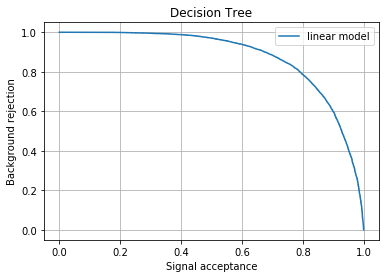

In [25]:
plt.plot( tpr,  np.abs(1-fpr), label = 'linear model')
plt.xlabel('Signal acceptance')
plt.ylabel('Background rejection')
plt.title('Decision Tree')
plt.grid()
plt.legend()
print('roc_auc = '+ str(metrics.roc_auc_score(test_Y, ypred2)))

C:\Users\zaret\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\zaret\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Decision Tree')

<Figure size 2880x2160 with 0 Axes>

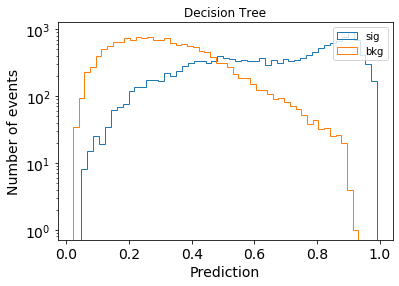

In [26]:
A = np.array(ypred[:,1])
idx_sig = np.where(test_Y == 1)[0] #signal
idx_bkg = np.where(test_Y == 0)[0]# выдает номера 


# Histogram predictions without error bars: #количес
bins = 50
fig14 = plt.figure(figsize=(40,30))
fig14, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(A[[idx_sig]], histtype='step', label='sig', bins = bins)
n2, bins2, patches2 = ax.hist(A[[idx_bkg]], histtype='step', label='bkg', bins = bins)
ax.set_xlabel('Prediction', {'fontsize': 14})
ax.set_ylabel('Number of events', {'fontsize': 14})
plt.yticks((10**0, 10**1, 10**2, 10**3), color='k', size=14)
plt.xticks((0.0, 0.2, 0.4, 0.6, 0.8, 1.0), color='k', size=14)
plt.yscale('log')
plt.legend(loc="upper right")
#fig14.savefig("predictions.pdf", bbox_inches='tight')
plt.title('Decision Tree')

In [27]:
print ('f1= ' +str(metrics.f1_score(test_Y, ypred2)))

f1= 0.7792734015520912


In [28]:
sklearn.metrics.confusion_matrix(test_Y, ypred2)

array([[13805,  2262],
       [ 4166, 11347]], dtype=int64)

In [29]:
# tn, fp, 
# fn, tp

## Тест на реальных данных 

In [30]:
test_X = pd.read_csv('/Users/zaret/Desktop/gerda/ANG5_cal.csv')
test_X.drop(test_X.columns[[0]], axis  =1, inplace = True)
test_Y = test_X['label']
test_X = test_X.drop('label', axis  =1)

test_X = test_X.drop('integral', axis = 1)

for i in range (1,49):
    test_X.drop('integral'+str(i), axis = 1, inplace = True)
    
test_X.drop('derivative49', axis = 1, inplace = True)


for i in range(1, 49):
    test_X.drop('derivative'+str(i), axis = 1, inplace = True)

In [31]:
ypred = xgbc.predict_proba(test_X)

In [32]:
ypred

array([[0.8779249 , 0.12207505],
       [0.19232154, 0.80767846],
       [0.25476396, 0.74523604],
       ...,
       [0.1339373 , 0.8660627 ],
       [0.41151845, 0.58848155],
       [0.33756852, 0.6624315 ]], dtype=float32)

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(test_Y, ypred[:, 1])

In [38]:
thrs =0.5

In [40]:
ypred2 = (ypred[:, 1]>=thrs)

In [41]:
print ('accuracy = ' + str(metrics.accuracy_score(test_Y, ypred2)))

accuracy = 0.6398004950859048


roc_auc = 0.6398004950859049


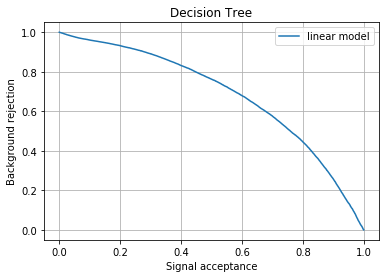

In [44]:
plt.plot( tpr,  np.abs(1-fpr), label = 'linear model')
plt.xlabel('Signal acceptance')
plt.ylabel('Background rejection')
plt.title('Decision Tree')
plt.grid()
plt.legend()
print('roc_auc = '+ str(metrics.roc_auc_score(test_Y, ypred2)))

C:\Users\zaret\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\zaret\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Decision Tree')

<Figure size 2880x2160 with 0 Axes>

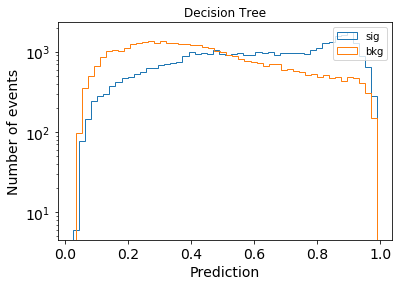

In [45]:
A = np.array(ypred[:,1])
idx_sig = np.where(test_Y == 1)[0] #signal
idx_bkg = np.where(test_Y == 0)[0]# выдает номера 


# Histogram predictions without error bars: #количес
bins = 50
fig14 = plt.figure(figsize=(40,30))
fig14, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(A[[idx_sig]], histtype='step', label='sig', bins = bins)
n2, bins2, patches2 = ax.hist(A[[idx_bkg]], histtype='step', label='bkg', bins = bins)
ax.set_xlabel('Prediction', {'fontsize': 14})
ax.set_ylabel('Number of events', {'fontsize': 14})
plt.yticks((10**0, 10**1, 10**2, 10**3), color='k', size=14)
plt.xticks((0.0, 0.2, 0.4, 0.6, 0.8, 1.0), color='k', size=14)
plt.yscale('log')
plt.legend(loc="upper right")
#fig14.savefig("predictions.pdf", bbox_inches='tight')
plt.title('Decision Tree')

In [46]:
print ('f1= ' +str(metrics.f1_score(test_Y, ypred2)))

f1= 0.6430245691592077


In [47]:
sklearn.metrics.confusion_matrix(test_Y, ypred2)

array([[25736, 15065],
       [14328, 26473]], dtype=int64)

In [48]:
# tn, fp, 
# fn, tp

## Вывод: по этому критерию синтезированные данные соответствуют реальным  